In [44]:
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorIndexer
import pyspark.sql.functions as F
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
df_new = spark.read.format('csv').option('header', 'true').load('D://ML-jupyter-main/mycsv.csv', inferSchema =True)

In [4]:
df_new.show(1, vertical = True, truncate=False)

-RECORD 0------------------
 _c0                 | 0   
 num                 | 9   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 2.0 
 aov                 | 0.0 
 target              | 1   
 unigenders_dum      | 0.0 
only showing top 1 row



<AxesSubplot: >

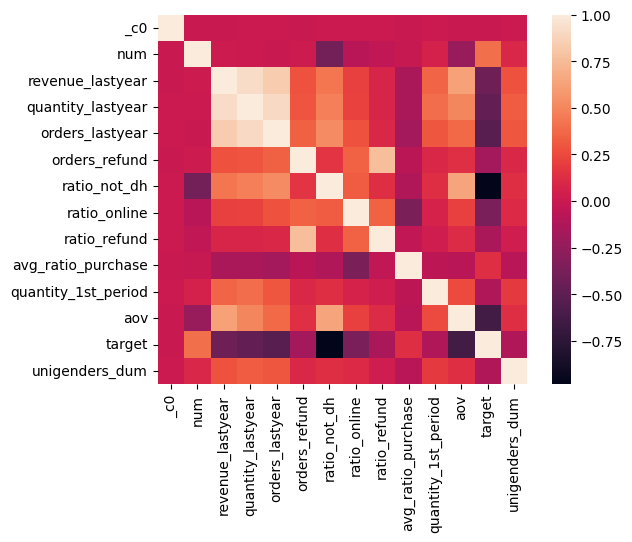

In [10]:
# отрисовка хитмап корреляций
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_new.columns, outputCol=vector_col)
df_vector = assembler.transform(df_new).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

corr = matrix.collect()[0]["pearson({})".format(vector_col)].values
corr_1 = corr.reshape(int(len(corr)**0.5), int(len(corr)**0.5))
sns.heatmap(corr_1, square = True, xticklabels = df_new.columns, yticklabels = df_new.columns)

In [12]:
# забиваем все фичи в один кортеж, кроме целевой колонки 'revenue_lastyear', лишние колонки также дропаем
assembler = VectorAssembler(inputCols = df_new.drop('revenue_lastyear', 'ratio_not_dh', '_c0').columns, outputCol = 'features')
output = assembler.transform(df_new)
output.show(1, vertical=True, truncate=False)

-RECORD 0-----------------------------------------------
 _c0                 | 0                                
 num                 | 9                                
 revenue_lastyear    | 0.0                              
 quantity_lastyear   | 0                                
 orders_lastyear     | 0                                
 orders_refund       | 0                                
 ratio_not_dh        | 0.0                              
 ratio_online        | 0.0                              
 ratio_refund        | 0.0                              
 avg_ratio_purchase  | 1.0                              
 quantity_1st_period | 2.0                              
 aov                 | 0.0                              
 target              | 1                                
 unigenders_dum      | 0.0                              
 features            | (11,[0,6,7,9],[9.0,1.0,2.0,1.0]) 
only showing top 1 row



In [45]:
# скалируем фичи,на выходе колонка "scaledFeatures"
scaler = StandardScaler(inputCol='features', outputCol="scaledFeatures",
                                withStd=True, withMean=True)
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)
scaledData.show(1, vertical = True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 _c0                 | 0                                                                                                                                                                                                                              
 num                 | 9                                                                                                                                                                                                                              
 revenue_lastyear    | 0.0                                                                                                                                                                                                                            
 quantity_la

In [46]:
# индексирование фичей, заменяем категориальные данные (<=3 различных значений в колонке)
featureIndexer =\
    VectorIndexer(inputCol="scaledFeatures", outputCol="indexedFeatures", maxCategories=3).fit(scaledData)

In [52]:
# оставляем только нужные колонки, переименовываем, чтобы регрессор отличил фичи от лэйблов
data = scaledData.select(F.col('revenue_lastyear').alias('label'), F.col('scaledFeatures'))
data.show(1, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 label          | 0.0                                                                                                                                                                                                                            
 scaledFeatures | [0.16143704967509478,-0.5793495286269017,-0.6484783479664572,-0.21831216511061377,-0.5224816193892204,-0.18622890618535456,0.2196308663856279,-0.07922875909742796,-0.7717812359237602,1.2228237749951851,-0.2173984676136886] 
only showing top 1 row



In [53]:
# сплитим данные 80 трейн на 20 тест
(trainingData, testData) = data.randomSplit([0.8, 0.2])

In [54]:
# инициализируем регрессор, указываем индексы фичей
gbt = GBTRegressor(featuresCol="indexedFeatures", maxIter=10)

In [55]:
# пайплайн для обучения
pipeline = Pipeline(stages=[featureIndexer, gbt])

In [56]:
# обучаем
model = pipeline.fit(trainingData)

In [57]:
# предсказываем
predictions = model.transform(testData)

In [59]:
# смотрим на предсказания
predictions.select("prediction", "label", "indexedFeatures").show(5)

+-------------------+-----+--------------------+
|         prediction|label|     indexedFeatures|
+-------------------+-----+--------------------+
|-185.47735034171086|  0.0|[-0.3955393636784...|
|-185.47735034171086|  0.0|[-0.3955393636784...|
|-185.47735034171086|  0.0|[-0.3955393636784...|
|-185.47735034171086|  0.0|[-0.3955393636784...|
|-185.47735034171086|  0.0|[-0.3955393636784...|
+-------------------+-----+--------------------+
only showing top 5 rows



In [60]:
# убедимся в наличии разных предсказаний
predictions.groupby('prediction').count().show(10)

+-------------------+-----+
|         prediction|count|
+-------------------+-----+
|  201037.2611790428|   10|
| 196363.93056249313|    3|
| 213935.80473786022|   16|
| 204567.51903383806|    1|
| 137046.86503589957|    1|
| 131971.73216218155|    7|
|  288924.6005467472|    5|
|  314999.3346445235|    1|
|-185.47735034171086|23983|
|  63483.85205744365|    5|
+-------------------+-----+
only showing top 10 rows



In [63]:
# оценим модель по корню из средней квадратичной ошибки
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 8602.42


In [ ]:
# модель, в среднем, отклоняется от истинных показаний на 8600 пунктов